In [ ]:
### Transformers

In [ ]:
!pip install transformers torch scipy matplotlib pandas

Loading models.. 


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/202 [00:00<?, ?it/s]

BertForMaskedLM LOAD REPORT from: bert-base-uncased
Key                         | Status     |  | 
----------------------------+------------+--+-
bert.pooler.dense.weight    | UNEXPECTED |  | 
cls.seq_relationship.bias   | UNEXPECTED |  | 
cls.seq_relationship.weight | UNEXPECTED |  | 
bert.pooler.dense.bias      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/105 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

BERT Time: 20.19s
DistilBERT Time: 8.19s
Speedup: 2.46x faster


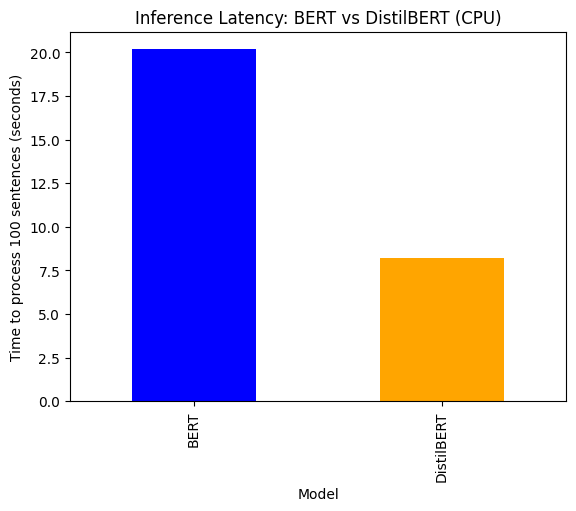

In [ ]:
import time
import torch
from transformers import pipeline
import pandas as pd
import matplotlib.pyplot as plt

print("Loading models.. ")
bert_pipe = pipeline("fill-mask", model="bert-base-uncased", device=-1) # CPU
distil_pipe = pipeline("fill-mask", model="distilbert-base-uncased", device=-1) # CPU


text = "The quick brown fox jumps over the [MASK] dog."
dataset = [text] * 100  # Repeat 100 times to simulate a workload


start = time.time()
for _ in dataset:
    bert_pipe(text)
bert_time = time.time() - start


start = time.time()
for _ in dataset:
    distil_pipe(text)
distil_time = time.time() - start

print(f"BERT Time: {bert_time:.2f}s")
print(f"DistilBERT Time: {distil_time:.2f}s")
print(f"Speedup: {bert_time/distil_time:.2f}x faster")


df = pd.DataFrame({'Model': ['BERT', 'DistilBERT'], 'Time (s)': [bert_time, distil_time]})
df.plot(kind='bar', x='Model', y='Time (s)', color=['blue', 'orange'], legend=False)
plt.title('Inference Latency: BERT vs DistilBERT (CPU)')
plt.ylabel('Time to process 100 sentences (seconds)')
plt.show()

                  He       She
Profession                    
doctor      0.614938  0.231986
nurse       0.012857  0.867102
engineer    0.872936  0.041046
teacher     0.500190  0.446460
CEO         0.824079  0.080196
assistant   0.524962  0.330062


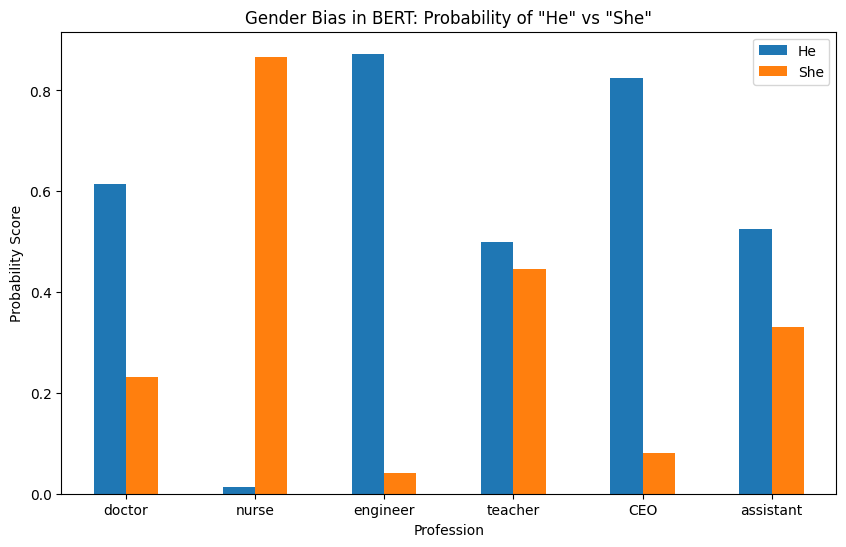

In [ ]:

professions = ["doctor", "nurse", "engineer", "teacher", "CEO", "assistant"]

results = []

for job in professions:

    sentence = f"[MASK] is a {job}."
    prediction = bert_pipe(sentence)

     he_score = 0
    she_score = 0

    for pred in prediction:
        if pred['token_str'] == "he":
            he_score = pred['score']
        elif pred['token_str'] == "she":
            she_score = pred['score']

    results.append({'Profession': job, 'He': he_score, 'She': she_score})


bias_df = pd.DataFrame(results).set_index('Profession')
print(bias_df)

bias_df.plot(kind='bar', figsize=(10, 6))
plt.title('Gender Bias in BERT: Probability of "He" vs "She"')
plt.ylabel('Probability Score')
plt.xticks(rotation=0)
plt.show()

Testing Nationality Bias: india vs america...
               India   America
Profession                    
doctor      0.011314  0.019560
nurse       0.005182  0.009550
engineer    0.014103  0.004902
teacher     0.017486  0.005658
ceo         0.022182  0.002403
assistant   0.018430  0.004188


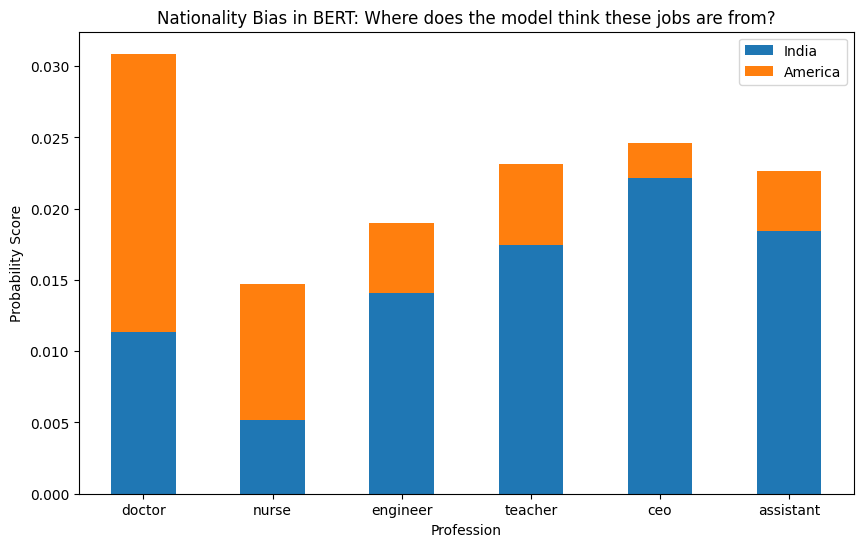

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


country1 = "india"
country2 = "america"
targets = [country1, country2]


professions = ["doctor", "nurse", "engineer", "teacher", "ceo", "assistant"]

results = []

print(f"Testing Nationality Bias: {country1} vs {country2}...")

for job in professions:
    sentence = f"The {job} is from [MASK]."


    prediction = bert_pipe(sentence, targets=targets)


    score_c1 = 0
    score_c2 = 0

    for pred in prediction:
        if pred['token_str'] == country1:
            score_c1 = pred['score']
        elif pred['token_str'] == country2:
            score_c2 = pred['score']

    results.append({'Profession': job, 'India': score_c1, 'America': score_c2})

bias_df = pd.DataFrame(results).set_index('Profession')
print(bias_df)

bias_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Nationality Bias in BERT: Where does the model think these jobs are from?')
plt.ylabel('Probability Score')
plt.xticks(rotation=0)
plt.show()